In [1]:
import model_api
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


## Train Networks on Midi Matrices

For the CNN, we will grab a fixed number of midi matrices per song (fill empty values with 0 matrices).
We'll use the stack of midi matrices as a three dimensional tensor input to be processed by convolutional layers.

The LSTM does not have the requirement of a fixed number of midi matrices, so we should be able to classify a song based on a variable number
of matrices.

I'll construct separate training sets based on the requirements of each model.

### CNN
The following code blocks construct the dataset for the convolutional neural network.

In [2]:
# Import Pretty MIDI data
fs2 = np.load("PreprocessedMidis/midisOP2_Fs2.npz")
song_keys = list(fs2.keys())
npz_labels = np.load("PreprocessedMidis/y_labels.npz")
label_keys = list(npz_labels.keys())

examples = []

longest_song = 0
for song in song_keys:
    song_array = fs2[song]
    song_length = song_array.shape[0]
    
    longest_song = max(song_length, longest_song)

print(f"Longest Song: {longest_song}")

Longest Song: 10338


#### Dataset Construction
Songs are variable in length and this is reflected in the feature extraction. The number of (36,3) matriceds per song is directly related to song-length. To reconcile the variable length input with the fixed dimensional inputs required my Convolutional Neural Network, our group decides to create several labels per song. We settled on creating as many (100, 36, 3) tensors as we could for each song, zero-padding the final tensor so that the information can still be used in training. For each of these tensors, we will attach the label of the original song. This process turns out training set of 1634 songs into 8752 tensors and labels.

In [3]:
def split_and_pad(array, target_shape=(100,36,3)):
    n, w, c = array.shape
    target_n, target_w, target_c = target_shape
    
    num_full_chunks = n // target_n
    chunks = [array[i*target_n:(i+1)*target_n] for i in range(num_full_chunks)]
    
    remainder = n % target_n
    if remainder > 0:
        remainder_array = array[num_full_chunks*target_n:]
        
        # Zero-pad the remainder array if it's smaller than the target size
        padding = ((0, target_n - remainder), (0, 0), (0, 0))
        padded_remainder = np.pad(remainder_array, padding, mode='constant', constant_values=0)
        chunks.append(padded_remainder)
    
    return chunks

In [4]:
examples = []
labels = []

for song, l_key in zip(song_keys, label_keys):
    song_array = fs2[song]
    label_value = npz_labels[l_key]

    chunks = split_and_pad(song_array)
    for chunk in chunks:
        examples.append(chunk)
        labels.append(label_value)

examples = np.array(examples)
labels = np.array(labels)

print("Examples Shape: ", examples.shape)
print("Labels Shape: ", labels.shape)

Examples Shape:  (8752, 100, 36, 3)
Labels Shape:  (8752, 4)


In [5]:

X_train, X_test, y_train, y_test = train_test_split(examples, labels, test_size=0.2, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.1, random_state=1)

print(f"Training Set Size: {X_train.shape}")
print(f"Validation Set Size: {X_val.shape}")
print(f"Test Set Size: {X_test.shape}")

print(f"Training Label Size: {y_train.shape}")
print(f"Validation Label Size: {y_val.shape}")
print(f"Test Label Size: {y_test.shape}")

Training Set Size: (7001, 100, 36, 3)
Validation Set Size: (176, 100, 36, 3)
Test Set Size: (1575, 100, 36, 3)
Training Label Size: (7001, 4)
Validation Label Size: (176, 4)
Test Label Size: (1575, 4)


### CNN Training and Hyperparameter Tuning
Our convolutional neural network model only has two tunable hyperparameters.
These hyperparameters are dropout rate and hidden layer number. Our group decided to use a grid_search over the hyperparameters to find the model scoring the best on the validation set.

Once we have the model with the best validation accuracy, we will use this model on the test set and evaluate the performance of the convolutional neural network.

In [6]:
EPOCHS = 100
def train_cnn_model(dropout, hidden_layers):
    cnn = model_api.opt2_cnn(100, 4, hidden_layers, dropout_rate=dropout)
    history = cnn.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=32, verbose=0)
    
    val_accuracy = history.history["val_accuracy"][-1]
    val_loss = history.history["val_loss"][-1]
                               
    return cnn, val_accuracy, val_loss, history

In [8]:
# Grid Search Training Loop
dropout_values = np.linspace(0.1, 0.5, 5)
hidden_layer_values = [2, 3, 4, 5]

val_accuracies = np.zeros((len(hidden_layer_values), len(dropout_values)))
val_losses = np.zeros((len(hidden_layer_values), len(dropout_values)))

best_model = None
best_acc = -1
best_training_history = None

for i, hidden_layers in enumerate(hidden_layer_values):
    for j, dropout_rate in enumerate(dropout_values):
        print(f"Training Dropout: {dropout_rate} Hidden Layer: {hidden_layers}")
        model, val_acc, val_loss, train_history = train_cnn_model(dropout_rate, hidden_layers)
        
        val_accuracies[i, j] = val_acc
        val_losses[i, j] = val_loss
        
        if val_acc > best_acc:
            best_model = model
            best_acc = val_acc
            best_training_history = train_history


Training Dropout: 0.1 Hidden Layer: 2
Training Dropout: 0.2 Hidden Layer: 2
Training Dropout: 0.30000000000000004 Hidden Layer: 2
Training Dropout: 0.4 Hidden Layer: 2
Training Dropout: 0.5 Hidden Layer: 2
Training Dropout: 0.1 Hidden Layer: 3
Training Dropout: 0.2 Hidden Layer: 3
Training Dropout: 0.30000000000000004 Hidden Layer: 3
Training Dropout: 0.4 Hidden Layer: 3
Training Dropout: 0.5 Hidden Layer: 3
Training Dropout: 0.1 Hidden Layer: 4
Training Dropout: 0.2 Hidden Layer: 4
Training Dropout: 0.30000000000000004 Hidden Layer: 4
Training Dropout: 0.4 Hidden Layer: 4
Training Dropout: 0.5 Hidden Layer: 4
Training Dropout: 0.1 Hidden Layer: 5
Training Dropout: 0.2 Hidden Layer: 5
Training Dropout: 0.30000000000000004 Hidden Layer: 5
Training Dropout: 0.4 Hidden Layer: 5
Training Dropout: 0.5 Hidden Layer: 5


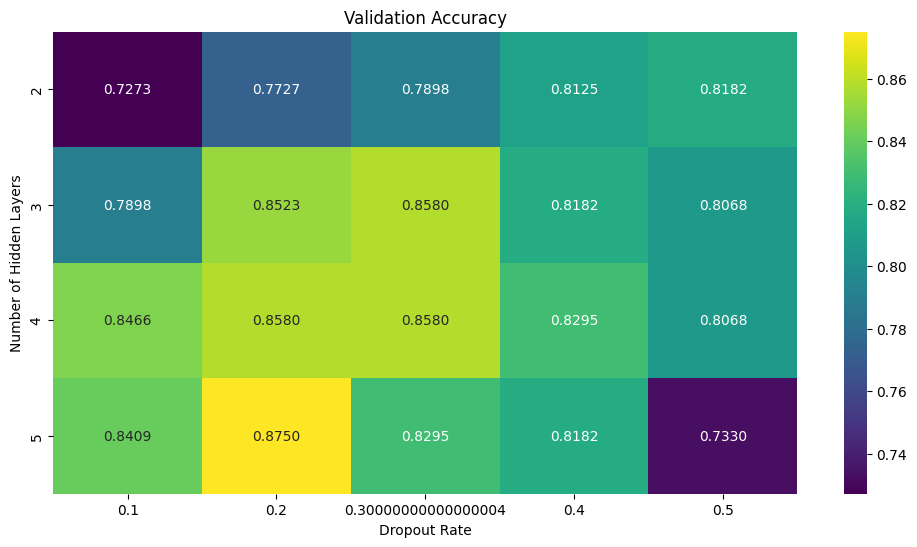

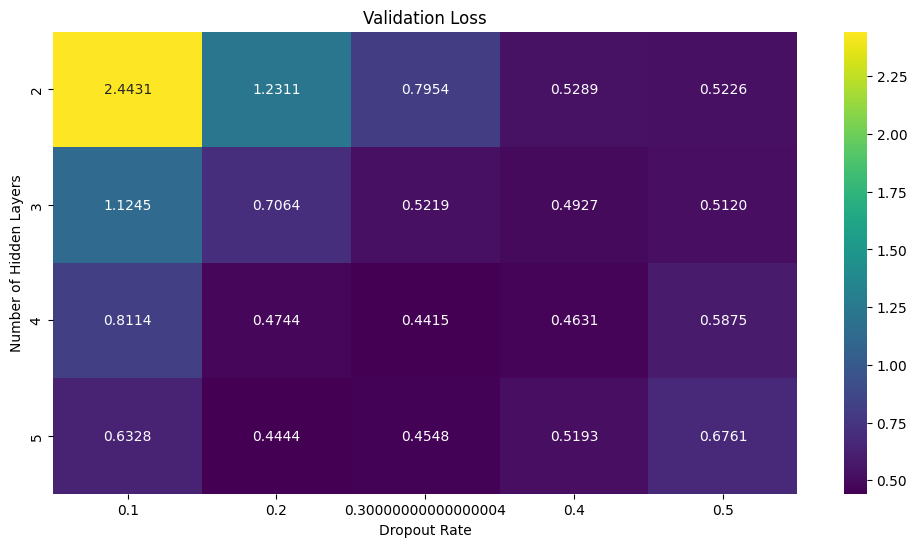

In [10]:
# Heatmap for Validation Accuracy
plt.figure(figsize=(12, 6))
sns.heatmap(val_accuracies, annot=True, fmt=".4f", xticklabels=dropout_values, yticklabels=hidden_layer_values, cmap='viridis')
plt.title('Validation Accuracy')
plt.xlabel('Dropout Rate')
plt.ylabel('Number of Hidden Layers')
plt.show()

# Heatmap for validation loss
plt.figure(figsize=(12, 6))
sns.heatmap(val_losses, annot=True, fmt=".4f", xticklabels=dropout_values, yticklabels=hidden_layer_values, cmap='viridis')
plt.title('Validation Loss')
plt.xlabel('Dropout Rate')
plt.ylabel('Number of Hidden Layers')
plt.show()

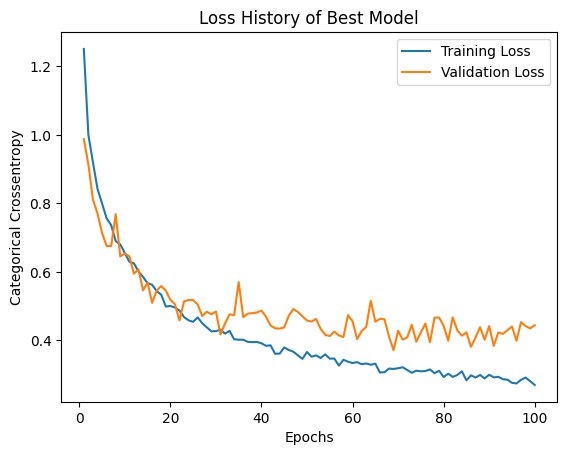

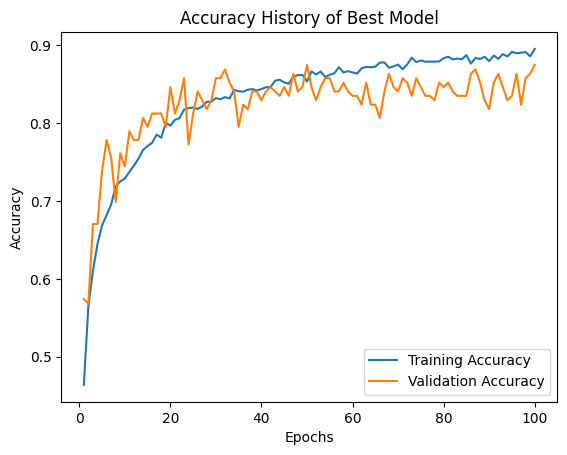

50/50 [==============================] - 1s 10ms/step - loss: 0.4190 - accuracy: 0.8514
Best Model Test Loss: 0.41902217268943787
Best Model Test Accuracy: 0.8514285683631897


In [11]:
train_loss = best_training_history.history["loss"]
val_loss = best_training_history.history["val_loss"]


train_acc = best_training_history.history["accuracy"]
val_acc = best_training_history.history["val_accuracy"]

plt.plot(range(1,EPOCHS+1), train_loss, label="Training Loss")
plt.plot(range(1,EPOCHS+1), val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Categorical Crossentropy")
plt.legend()
plt.title("Loss History of Best Model")
plt.show()

plt.plot(range(1,EPOCHS+1), train_acc, label="Training Accuracy")
plt.plot(range(1,EPOCHS+1), val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy History of Best Model")
plt.show()

test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Best Model Test Loss: {test_loss}")
print(f"Best Model Test Accuracy: {test_accuracy}")

In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score
# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print("Best Model Ancillary Results")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

50/50 [==============================] - 0s 5ms/step
Best Model Ancillary Results
Precision: 0.8541
Recall: 0.8514
F1-Score: 0.8526
